# Курсовой проект по курсу: Библиотеки Python для Data Science. Продоолжение



# Оглавление <a name='index'>

 Загрузка всего
 
**[Смотрим Пропуски](#nulls)**

**[Служебные функции](#work)**

**Обзор Данных:**

* **[Home Ownership](#1_hw)** - домовладение `dummies`
* **[Annual Income](#2_ai)** - годовой доход (**1557 пропусков**) 

    * `Заполняем пропуки при помощи Линейной регрессии`
* **[Years in current job](#3_yicj)** - количество лет на текущем месте работы (**371 пропуск**) `категории + пропуски в отдельную`
* **[Tax Liens](#4_tl)** - **---** налоговые обременения
* **[Number of Open Accounts](#5_nooa)** - количество открытых счетов -
* **[Years of Credit History](#6_yoch)** - количество лет кредитной истории -
* **[Maximum Open Credit](#7_moc)** - наибольший открытый кредит `заменяем > 95 квантили на медиану`
* **[Number of Credit Problems](#8_nocp)** - **---** количество проблем с кредитом 
* **[Months since last delinquent](#9_msld)** - количество месяцев с последней просрочки платежа (**4071 пропуск**) `null в 0 + в отдельный столбец. меняем >99 проц на среднее..`
* **[Bankruptcies](#10_b)** - банкротства (**14 пропусков**) `null в 0`
* **[Purpose](#11_p)** - цель кредита `в категории + объединяем категории чтобы осталось 4`
* **[Term](#12_t)** - срок кредита `в 2 категории`
* **[Current Loan Amount](#13_cla)** - текущая сумма кредита `выбросы в отделную переменную`
* **[Current Credit Balance](#14_ccb)** - текущий кредитный баланс `меняем >99 проц на среднее..`
* **[Monthly Debt](#15_md)** - ежемесячный долг `меняем >99 проц на среднее..`
* **[Credit Score](#16_cs)** - кредитный рейтинг (**1557 пропусков**) `делим на категории + null в отделную категорию`
* **[Credit Default](#17_cd)** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка) 

**[Заполнение Month since last delinquent на основе других столбцов](#monthNULL)** - `НЕ РАБОТАЕТ`

**[Новый признак](#new)** - вместо `Tax Liens`, `Number of Credit Problems` и `Bankruptcies` делаю один признак, а эти исключаю

**[Смотрим, что получилось после обработки данных](#look)**

**[Нормализация данных](#norm) + Отбор данных для CatBoost** `выключено, потому-что с ним результат хуже`

**[Обучение на моделях](#20_learn)**

* **[Список моделей](#21_learn1)**


## Загрузка всего <a name='load'></a>

[к оглавлению](#index)

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# Загрузка библиотек:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Алгоритмы кластеризации (какие нашел)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# для статистики
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

In [3]:
# Загрузка наборов данных:

df = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

In [4]:
# Добавляем в тренировочный набор нанных поле ID

df['ID'] = df.index.tolist()

## Обзор данных <a name='view'>
    
[к оглавлению](#index)

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [6]:
df.shape

(7500, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


## Пропуски <a name="nulls"></a>

`на train и test пропуски совпадают`

[к оглавлению](#index)

In [9]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [10]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

## Служебные функции <a name="work"></a>

[к оглавлению](#index)

In [11]:
# функция показывает корреляцию мжду двумя группами одного признака в отношении целевого признака. 
# если результат больше 0.05 - можно объединять в один
def corr_(val, x1, x2):
    pay1_and_target_s = df.loc[df[val].isin([x1, x2]), ['ID', val, 'Credit Default']]#.sample(1000)
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(p)
    
    
# метрики в читеамом виде
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def mis_values_report(df):
    '''Функция считает и выводит пропущенные значения столбцов датафрейма'''
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns

In [12]:
mis_values_report(df)

Датафрейм имеет 18 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


# Обработка данных

### Home Ownership - домовладение <a name="1_hw"></a>

[к оглавлению](#index)

In [13]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

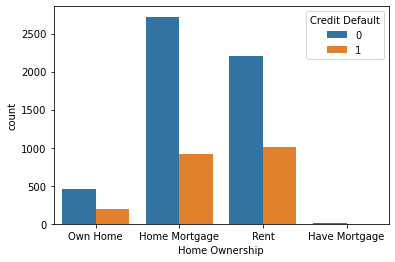

In [14]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [15]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

### Annual Income - годовой доход <a name="2_ai"></a>

[к оглавлению](#index)

In [16]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

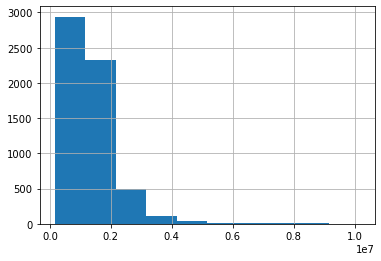

In [17]:
df['Annual Income'].hist()

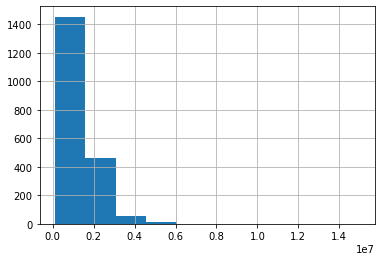

In [18]:
df_test['Annual Income'].hist()

In [19]:
# df.loc[df['Annual Income'].isnull(), 'Annual Income'] = 0
# df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = 0

#### Заполняем попуски и выбросы при помощи Линейной Регрессии `для примера заполнения. при включении результат падает!`

In [20]:
# df.loc[(df['Annual Income'] > df['Annual Income'].quantile(.95)), :].shape

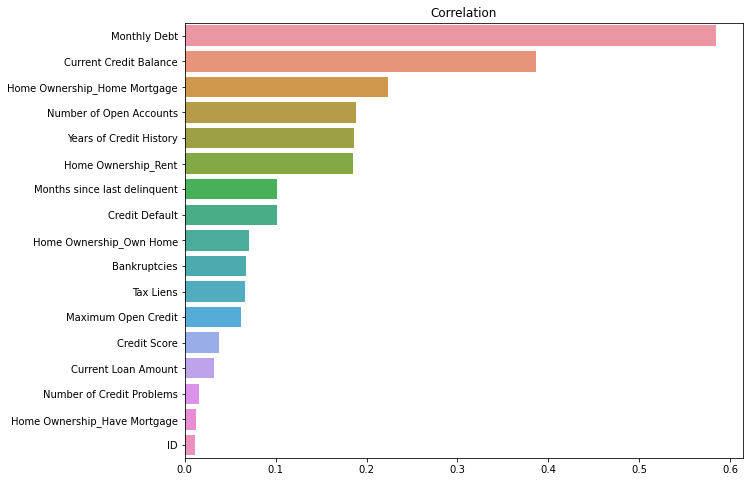

In [21]:
# смотрим, как коррелируют признаки с 'Annual Income'

FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [22]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак сам имеет много null)
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [23]:
# отбираем набор данных для обучения
data = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]#.sample(2000)
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Number of Open Accounts,Years of Credit History,Home Ownership_Rent,Annual Income
0,7914.0,47386.0,0,11.0,26.3,0,482087.0
1,18373.0,394972.0,0,15.0,15.3,0,1025487.0
2,13651.0,308389.0,1,11.0,35.0,0,751412.0
3,11338.0,95855.0,0,8.0,22.5,0,805068.0
4,7180.0,93309.0,0,13.0,13.6,1,776264.0
...,...,...,...,...,...,...,...
7491,61150.0,108889.0,1,18.0,21.3,0,2833185.0
7493,27562.0,167428.0,0,14.0,16.5,1,1257610.0
7495,1900.0,73492.0,0,3.0,8.5,1,402192.0
7496,12783.0,456399.0,1,10.0,26.5,0,1533984.0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  5943 non-null   float64
 1   Current Credit Balance        5943 non-null   float64
 2   Home Ownership_Home Mortgage  5943 non-null   uint8  
 3   Number of Open Accounts       5943 non-null   float64
 4   Years of Credit History       5943 non-null   float64
 5   Home Ownership_Rent           5943 non-null   uint8  
 6   Annual Income                 5943 non-null   float64
dtypes: float64(5), uint8(2)
memory usage: 290.2 KB


In [25]:
%%time

# учимся

model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

Wall time: 5min 29s


LogisticRegression()

In [26]:
# заполняем в боевом наборе данных пропуски на основе обученной модели

df.loc[(df['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [27]:
# смотрим, какое распределение получилось

shapiro(df['Annual Income'])

ShapiroResult(statistic=0.754403829574585, pvalue=0.0)

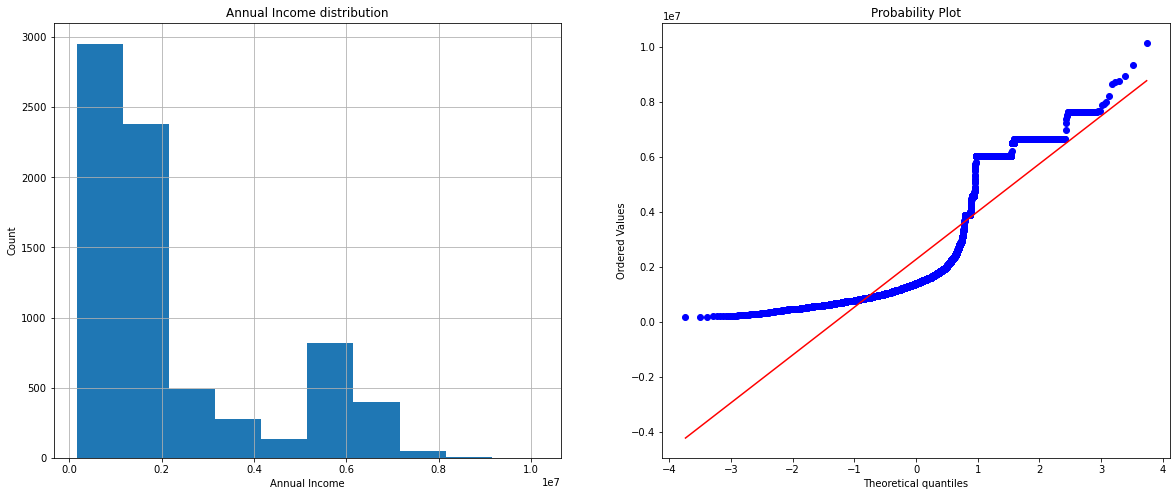

In [28]:
def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)

    plt.show()
    
hist_qq('Annual Income')

In [29]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]#.sample(1000)
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [30]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=5486954.0, pvalue=0.007655524784304955)

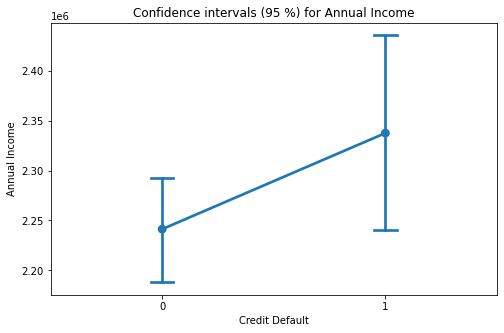

In [31]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

In [32]:
# прогоняем через функцию log. Нормализация

# def boxcox(y):
#     return [np.log(i) if i != 0 else 0 for i in y]

In [33]:
# df['Annual Income'] = boxcox(df.loc[:, 'Annual Income'])

In [34]:
# df['Annual Income'].describe()

In [35]:
# df.info()

### Years in current job - количество лет на текущем месте работы <a name="3_yicj"></a>

[к оглавлению](#index)

In [36]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

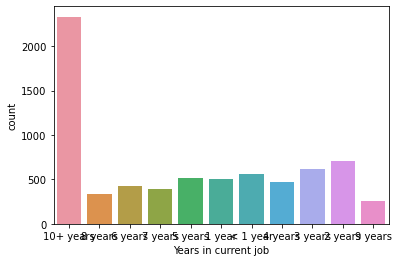

In [37]:
sns.countplot(x="Years in current job", data=df)
plt.show()

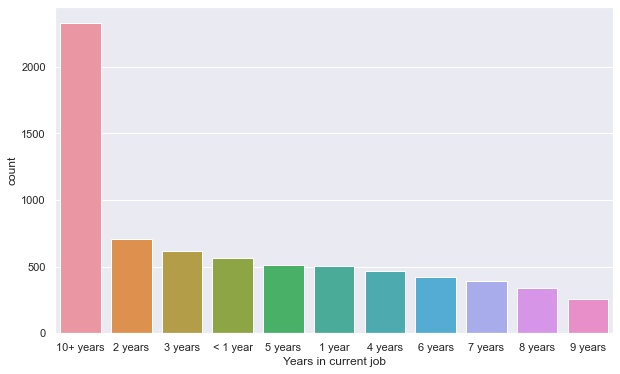

In [38]:
# посмотрим как выглядит распределение от стажа на месте
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df['Years in current job'], order = df['Years in current job'].value_counts().index)

In [39]:
df['Years in current job'] = df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

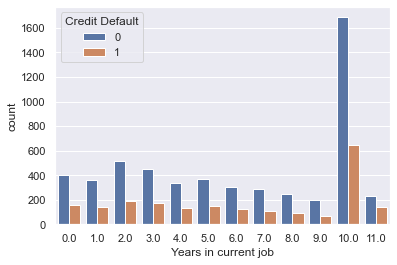

In [40]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.show()

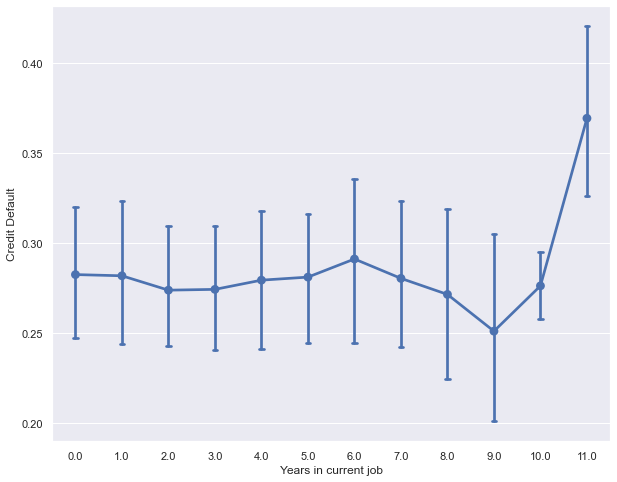

In [41]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df, capsize=.1,);

In [42]:
# другой ВАРИАНТ: можно попробовать поделить все вообще на 2 категории. Но при этом почему-то на test результат чуть хуже...

# df.loc[(df['Years in current job'] < 11), 'Years in current job'] = 1
# df.loc[(df['Years in current job'] == 11), 'Years in current job'] = 0

### Tax Liens - налоговые обременения <a name="4_tl"></a>

[к оглавлению](#index)

In [43]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

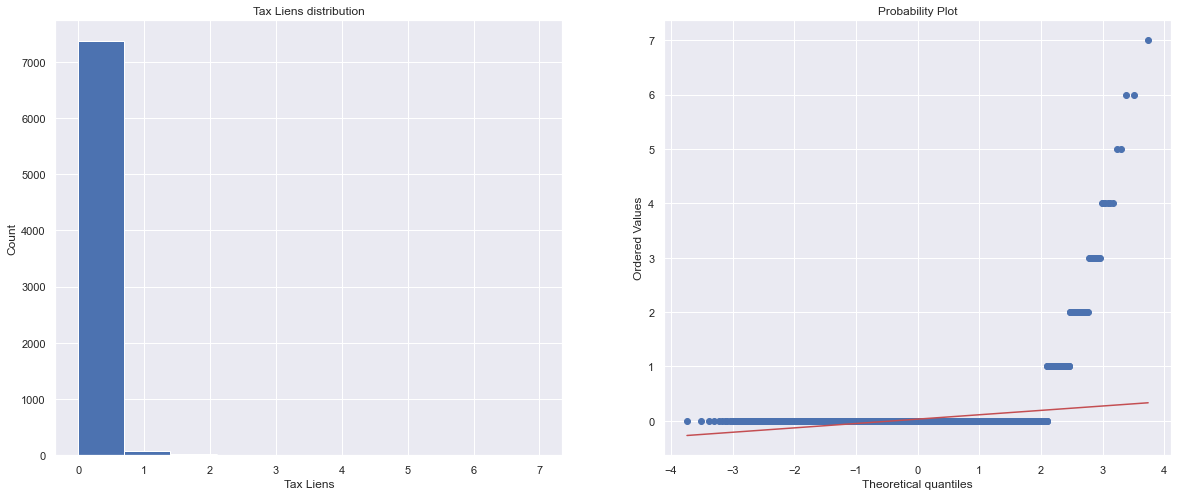

In [44]:
hist_qq('Tax Liens')

In [45]:
# df_test['Tax Liens'].hist()

In [46]:
# df.loc[(df['Tax Liens'] > 0), 'Tax Liens'] = 1

In [47]:
# df['Tax Liens'].value_counts()

In [48]:
# sns.countplot(x="Tax Liens", hue='Credit Default', data=df)
# plt.show()

In [49]:
# df['No Tax Liens'] = (df['Tax Liens'] == 0)

In [50]:
# df['No Tax Liens'].value_counts()

In [51]:
# corr_('Tax Liens',0,1)

### Number of Open Accounts - количество открытых счетов <a name="5_nooa"></a>

[к оглавлению](#index)

In [52]:
# df['Number of Open Accounts'].describe()

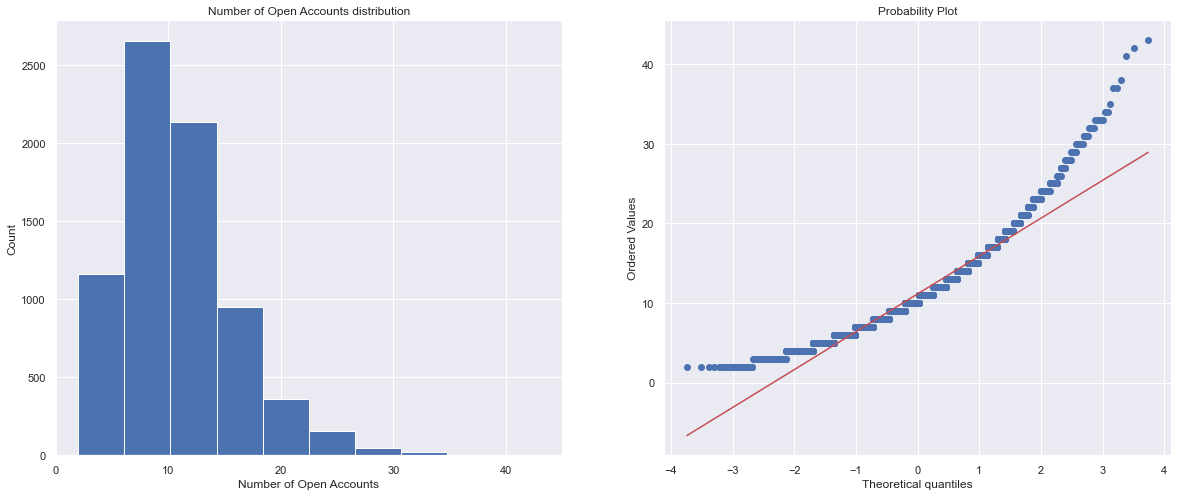

In [53]:
hist_qq('Number of Open Accounts')

In [54]:
# df_test['Number of Open Accounts'].describe()

In [55]:
# df['Number of Open Accounts'].hist()

# plt.figure(figsize=(20, 8))
# sns.countplot(x="Number of Open Accounts", hue='Credit Default', data=df)
# plt.show()

In [56]:
# ВАРИАНТ 2 - вообще ничего не делать

# df.loc[(df['Number of Open Accounts'] >= 22), 'Number of Open Accounts'] = 4

# df.loc[(df['Number of Open Accounts'] < 7),'Number of Open Accounts'] = 0
# df.loc[(df['Number of Open Accounts'] >= 7) & (df['Number of Open Accounts'] < 9),'Number of Open Accounts'] = 1
# df.loc[(df['Number of Open Accounts'] >= 9) & (df['Number of Open Accounts'] < 15),'Number of Open Accounts'] = 2
# df.loc[(df['Number of Open Accounts'] >= 15) & (df['Number of Open Accounts'] < 22),'Number of Open Accounts'] = 3
# df.loc[(df['Number of Open Accounts'] >= 11),'Number of Open Accounts'] = 4


In [57]:
# sns.countplot(x="Number of Open Accounts", hue='Credit Default', data=df)
# plt.show()

In [58]:
# corr_('Number of Open Accounts',0,1)
# corr_('Number of Open Accounts',0,2)
# corr_('Number of Open Accounts',0,3)

# corr_('Number of Open Accounts',1,2)
# corr_('Number of Open Accounts',1,3)

# corr_('Number of Open Accounts',2,3)

### Years of Credit History - коичество лет кредитной истории <a name="6_yoch"></a>

[к оглавлению](#index)

In [59]:
# df['Years of Credit History'].value_counts()

In [60]:
# df['Years of Credit History'].hist()

In [61]:
# df_test['Years of Credit History'].hist()

In [62]:
# df.loc[(df['Years of Credit History'] < 7),'Years of Credit History'] = 0
# df.loc[(df['Years of Credit History'] >= 7) & (df['Years of Credit History'] < 10),'Years of Credit History'] = 1
# df.loc[(df['Years of Credit History'] >= 10) & (df['Years of Credit History'] < 20),'Years of Credit History'] = 2
# df.loc[(df['Years of Credit History'] >= 20) & (df['Years of Credit History'] < 30),'Years of Credit History'] = 3
# df.loc[(df['Years of Credit History'] >= 30),'Years of Credit History'] = 4

In [63]:
# sns.countplot(x="Years of Credit History", hue='Credit Default', data=df)
# plt.show()

In [64]:
# df.loc[(df['Years of Credit History'] > 40), 'Years of Credit History'] = 40

# на ТЕСТЕ
# df_test.loc[(df_test['Years of Credit History'] > 40), 'Years of Credit History'] = 40

In [65]:
# corr_('Years of Credit History',0,1)
# corr_('Years of Credit History',0,2)
# corr_('Years of Credit History',0,3)
# corr_('Years of Credit History',0,4)

# corr_('Years of Credit History',1,2)
# corr_('Years of Credit History',1,3)
# corr_('Years of Credit History',1,4)

# corr_('Years of Credit History',2,3)
# corr_('Years of Credit History',2,4)

# corr_('Years of Credit History',3,4)

### Maximum Open Credit - наибольший открытый кредит <a name="7_moc"></a>

[к оглавлению](#index)

In [66]:
# df['Maximum Open Credit'].value_counts()

In [67]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

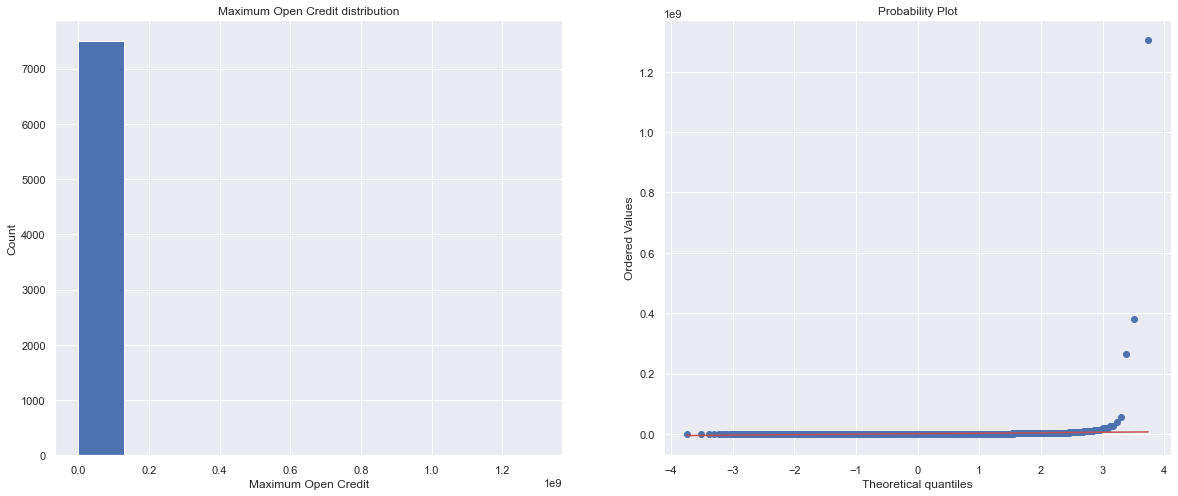

In [68]:
hist_qq('Maximum Open Credit')

In [69]:
df.loc[(df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95)), :].shape

(375, 22)

In [70]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df['Maximum Open Credit'].median()

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].median()

In [71]:
# df.loc[(df['Maximum Open Credit'] < 800000), 'Maximum Open Credit'] = 0
# df.loc[(df['Maximum Open Credit'] >= 200000) & (df['Maximum Open Credit'] < 400000), 'Maximum Open Credit'] = 1
# df.loc[(df['Maximum Open Credit'] >= 400000) & (df['Maximum Open Credit'] < 600000), 'Maximum Open Credit'] = 2
# df.loc[(df['Maximum Open Credit'] >= 600000) & (df['Maximum Open Credit'] < 800000), 'Maximum Open Credit'] = 3
# df.loc[(df['Maximum Open Credit'] >= 800000) & (df['Maximum Open Credit'] < 1000000), 'Maximum Open Credit'] = 4
# df.loc[(df['Maximum Open Credit'] >= 800000), 'Maximum Open Credit'] = 1


# на ТЕСТЕ
# df_test.loc[(df_test['Maximum Open Credit'] < 200000), 'Maximum Open Credit'] = 0
# df_test.loc[(df_test['Maximum Open Credit'] >= 200000) & (df_test['Maximum Open Credit'] < 400000), 'Maximum Open Credit'] = 1
# df_test.loc[(df_test['Maximum Open Credit'] >= 400000) & (df_test['Maximum Open Credit'] < 600000), 'Maximum Open Credit'] = 2
# df_test.loc[(df_test['Maximum Open Credit'] >= 600000) & (df_test['Maximum Open Credit'] < 800000), 'Maximum Open Credit'] = 3
# df_test.loc[(df_test['Maximum Open Credit'] >= 800000) & (df_test['Maximum Open Credit'] < 1000000), 'Maximum Open Credit'] = 4
# df_test.loc[(df_test['Maximum Open Credit'] >= 1000000), 'Maximum Open Credit'] = 5

In [72]:
# sns.countplot(x="Maximum Open Credit", hue='Credit Default', data=df)
# plt.show()

In [73]:
# corr_('Maximum Open Credit', 0, 1)

# corr_('Maximum Open Credit', 0, 2)
# corr_('Maximum Open Credit', 0, 3)
# corr_('Maximum Open Credit', 0, 4)
# corr_('Maximum Open Credit', 0, 5)

# corr_('Maximum Open Credit', 1, 2)
# corr_('Maximum Open Credit', 1, 3)
# corr_('Maximum Open Credit', 1, 4)
# corr_('Maximum Open Credit', 1, 5)

# corr_('Maximum Open Credit', 4, 5)

### Number of Credit Problems - количество проблем с кредитом <a name="8_nocp"></a>

[к оглавлению](#index)

In [74]:
# df['Number of Credit Problems'].value_counts()

In [75]:
# sns.countplot(x="Number of Credit Problems", data=df)
# plt.show()

In [76]:
# sns.countplot(x="Number of Credit Problems", data=df_test)
# plt.show()

In [77]:
# df.loc[(df['Number of Credit Problems'] > 0), 'Number of Credit Problems'] = 1

In [78]:
# sns.countplot(x="Number of Credit Problems", hue='Credit Default', data=df)
# sns.countplot(x="Number of Credit Problems", hue='Bankruptcies', data=df)
# plt.show()

In [79]:
# corr_('Number of Credit Problems', 0 , 1)
# corr_('Number of Credit Problems', 0 , 2)

# corr_('Number of Credit Problems', 1 , 2)

### Months since last delinquent - количество месяцев с последней просрочки кредита <a name=9_msld>
    
[к оглавлению](#index)

In [80]:
# df['Months since last delinquent'].describe()

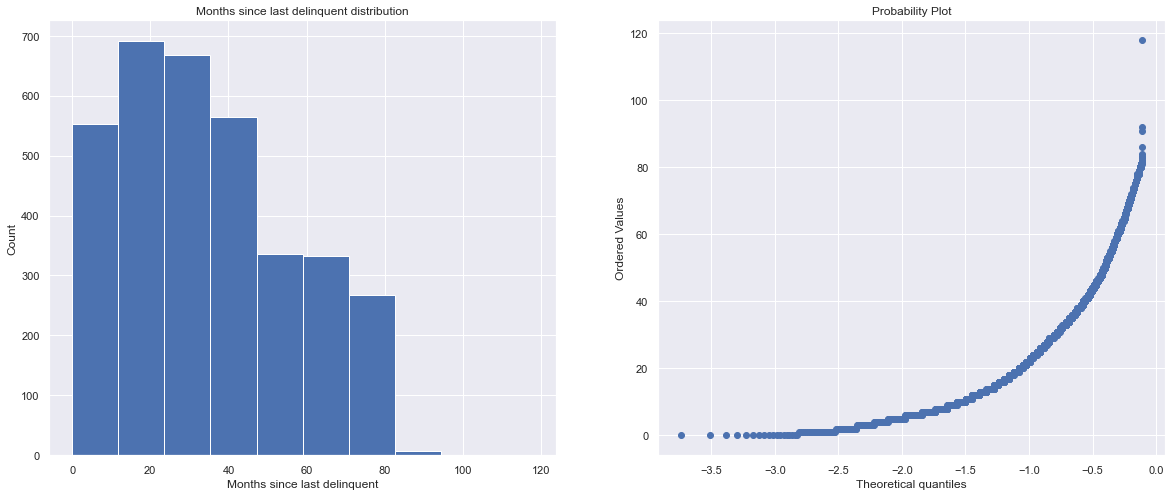

In [81]:
hist_qq('Months since last delinquent')

In [82]:
df.loc[df['Months since last delinquent'] > df['Months since last delinquent'].quantile(.99), :].shape

(31, 22)

In [83]:
df.loc[df['Months since last delinquent'] > df['Months since last delinquent'].quantile(.99), \
       ['Months since last delinquent']] = df['Months since last delinquent'].mean()

df_test.loc[df_test['Months since last delinquent'] > df_test['Months since last delinquent'].quantile(.99), \
       ['Months since last delinquent']] = df_test['Months since last delinquent'].mean()

In [84]:
# baseline. Null заменяем на 0 + выделяем в ОТДЕЛЬНЫЙ ПРИЗНАК

df['Months since last delinquent NULL'] = df['Months since last delinquent'].isnull()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
# df['Months since last delinquent'].fillna(0, inplace=True)

df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0




# -------------------------

# df.loc[(df['Months since last delinquent'] >= 0), 'Months since last delinquent'] = 0
# df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 1

# df_test.loc[(df_test['Months since last delinquent'] >= 0), 'Months since last delinquent'] = 0
# df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 1


# вариант 2

# df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
# df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Months since last delinquent'].mean()
# df.loc[(df['Months since last delinquent'] > 50), 'Months since last delinquent'] = 50

# df.loc[(df['Months since last delinquent'] == 0), 'Months since last delinquent'] = 0
# df.loc[(df['Months since last delinquent'] >= 0) & (df['Months since last delinquent'] < 12), 'Months since last delinquent'] = 0
# df.loc[(df['Months since last delinquent'] >= 12) & (df['Months since last delinquent'] < 24), 'Months since last delinquent'] = 1
# df.loc[(df['Months since last delinquent'] >= 24) & (df['Months since last delinquent'] < 36), 'Months since last delinquent'] = 2
# df.loc[(df['Months since last delinquent'] >= 36) & (df['Months since last delinquent'] < 48), 'Months since last delinquent'] = 3
# df.loc[(df['Months since last delinquent'] >= 48), 'Months since last delinquent'] = 4
# df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 5

# df_test.loc[(df_test['Months since last delinquent'] == 0), 'Months since last delinquent'] = 0
# df_test.loc[(df_test['Months since last delinquent'] >= 0) & (df_test['Months since last delinquent'] < 12), 'Months since last delinquent'] = 0
# df_test.loc[(df_test['Months since last delinquent'] >= 12) & (df_test['Months since last delinquent'] < 24), 'Months since last delinquent'] = 1
# df_test.loc[(df_test['Months since last delinquent'] >= 24) & (df_test['Months since last delinquent'] < 36), 'Months since last delinquent'] = 2
# df_test.loc[(df_test['Months since last delinquent'] >= 36) & (df_test['Months since last delinquent'] < 48), 'Months since last delinquent'] = 3
# df_test.loc[(df_test['Months since last delinquent'] >= 48), 'Months since last delinquent'] = 4
# df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 5

In [85]:
# sns.countplot(x="Months since last delinquent", hue='Credit Default', data=df)
# plt.show()

In [86]:
# sns.countplot(x="Months since last delinquent", data=df_test)
# plt.show()

In [87]:
# corr_('Months since last delinquent', 0,1)
# corr_('Months since last delinquent', 1,2)
# corr_('Months since last delinquent', 1,3)
# corr_('Months since last delinquent', 1,4)
# corr_('Months since last delinquent', 1,5)

# corr_('Months since last delinquent', 1,2)
# corr_('Months since last delinquent', 1,3)
# corr_('Months since last delinquent', 1,4)

### Bankruptcies - банкротства <a name=10_b>

[к оглавлению](#index)

In [88]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [89]:
df_test['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [90]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
# df.loc[(df['Bankruptcies'] > 0), 'Bankruptcies'] = 1

df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

In [91]:
# sns.countplot(x="Bankruptcies", hue='Credit Default', data=df)
# plt.show()

In [92]:
# corr_('Bankruptcies', 0,1)

### Purpose - цель кредита <a name=11_p>

[к оглавлению](#index)

In [93]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [94]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

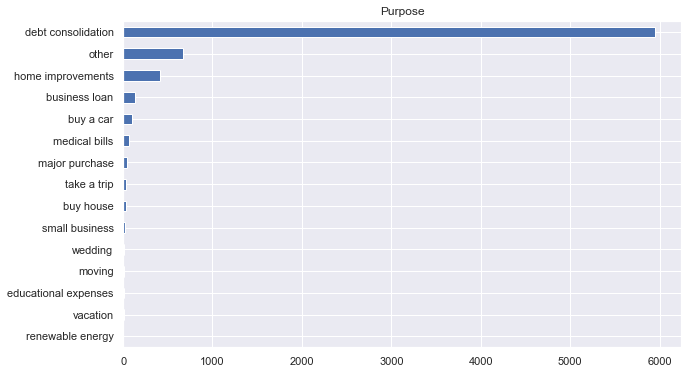

In [95]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

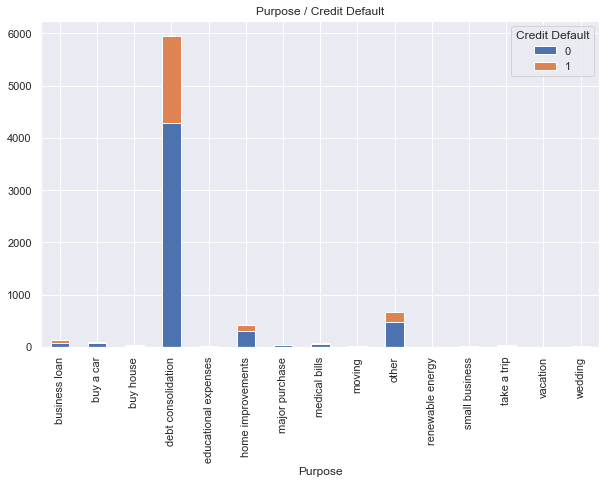

In [96]:
purpose_cr_deafult = df[['Purpose','Credit Default']]
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

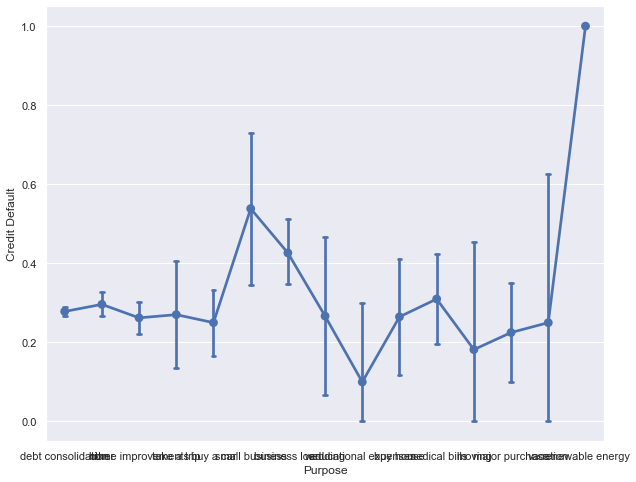

In [97]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [98]:
# по графику видно, что можно можно разделить всего на 4 категории

df['Purpose'] = df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

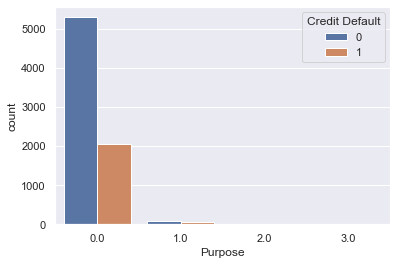

In [99]:
sns.countplot(x="Purpose", hue='Credit Default', data=df)
plt.show()

In [100]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

### Term - срок кредита - срок кредита <a name=12_t>

[к оглавлению](#index)

In [101]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

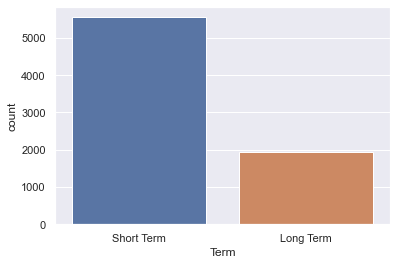

In [102]:
sns.countplot(x="Term", data=df)
plt.show()

In [103]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

In [104]:
# df['Term'].value_counts()

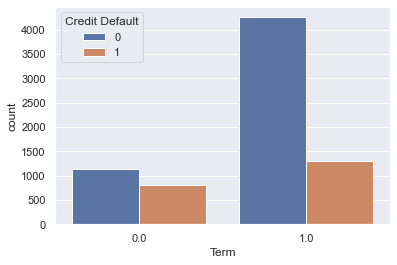

In [105]:
sns.countplot(x="Term", hue='Credit Default', data=df)
plt.show()

In [106]:
corr_('Term',0,1)

1.1519373940439208e-55


### Current Loan Amount - текущая сумма кредита <a name=13_cla>

`большие выбросы выделил в отдельную переменную (это вариант показал лучшие результаты)`
    
[к оглавлению](#index)

In [107]:
# df = pd.read_csv('course_project_train.csv')

In [108]:
df['Current Loan Amount'].value_counts()
# df['Current Loan Amount BIG'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [109]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

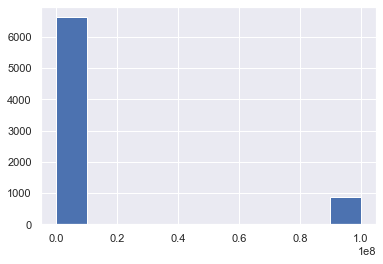

In [110]:
df['Current Loan Amount'].hist()

In [111]:
# вынос больших выбросов в отдельную переменную. результат не меняется: 0.53, 0.52, 0.52 || 0.53

df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

### Current Credit Balance - текущий кредитный баланс <a name=14_ccb>

[к оглавлению](#index)

In [112]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

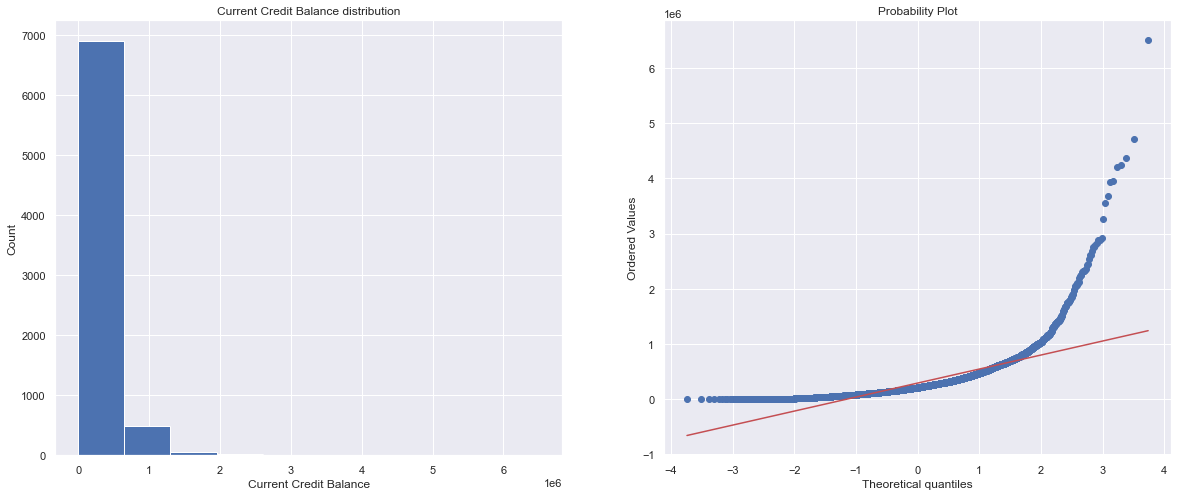

In [113]:
hist_qq('Current Credit Balance')

In [114]:
#выбросы

df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.99), :].shape

(75, 24)

In [115]:
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.99), \
       ['Current Credit Balance']] = df['Current Credit Balance'].mean()

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.99), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].mean()

In [116]:
# df.loc[(df['Current Credit Balance'] < 100000), 'Current Credit Balance'] = 0
# df.loc[(df['Current Credit Balance'] >= 100000) & (df['Current Credit Balance'] < 200000), 'Current Credit Balance'] = 1
# df.loc[(df['Current Credit Balance'] >= 200000) & (df['Current Credit Balance'] < 300000), 'Current Credit Balance'] = 2
# df.loc[(df['Current Credit Balance'] >= 300000) & (df['Current Credit Balance'] < 400000), 'Current Credit Balance'] = 3
# df.loc[(df['Current Credit Balance'] >= 400000), 'Current Credit Balance'] = 4


# df_test.loc[(df_test['Current Credit Balance'] < 100000), 'Current Credit Balance'] = 0
# df_test.loc[(df_test['Current Credit Balance'] >= 100000) & (df_test['Current Credit Balance'] < 200000), 'Current Credit Balance'] = 1
# df_test.loc[(df_test['Current Credit Balance'] >= 200000) & (df_test['Current Credit Balance'] < 300000), 'Current Credit Balance'] = 2
# df_test.loc[(df_test['Current Credit Balance'] >= 300000) & (df_test['Current Credit Balance'] < 400000), 'Current Credit Balance'] = 3
# df_test.loc[(df_test['Current Credit Balance'] >= 400000), 'Current Credit Balance'] = 4

In [117]:
# df['Current Credit Balance'].value_counts()

In [118]:
# sns.countplot(x="Current Credit Balance", hue='Credit Default', data=df)
# plt.show()

In [119]:
# corr_('Current Credit Balance', 0,1)
# corr_('Current Credit Balance', 1,2)
# corr_('Current Credit Balance', 2,3)
# corr_('Current Credit Balance', 3,5)

### Monthly Debt - ежемесячный долг <a name=15_md>

[к оглавлению](#index)

In [120]:
# df['Monthly Debt'].value_counts()

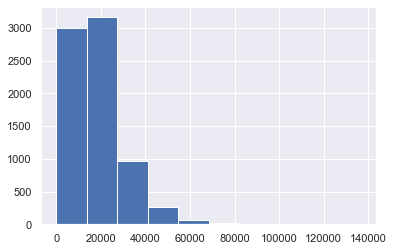

In [121]:
df['Monthly Debt'].hist()

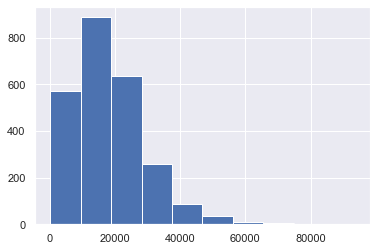

In [122]:
df_test['Monthly Debt'].hist()

In [123]:
df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

In [124]:
# df.loc[(df['Monthly Debt'] < 15000), 'Monthly Debt'] = 0

# df.loc[(df['Monthly Debt'] >= 15000) & (df['Monthly Debt'] < 25000), 'Monthly Debt'] = 1
# df.loc[(df['Monthly Debt'] >= 25000) & (df['Monthly Debt'] < 40000), 'Monthly Debt'] = 2
# df.loc[(df['Monthly Debt'] >= 40000) & (df['Monthly Debt'] < 55000), 'Monthly Debt'] = 3
# df.loc[(df['Monthly Debt'] >= 55000), 'Monthly Debt'] = 4

In [125]:
# sns.countplot(x="Monthly Debt", hue='Credit Default', data=df)
# plt.show()

In [126]:
# corr_('Monthly Debt', 0,1)
# corr_('Monthly Debt', 0,2)
# corr_('Monthly Debt', 0,3)
# corr_('Monthly Debt', 0,4)

### Credit Score - кредитный рейтинг <a name=16_cs>

[к оглавлению](#index)

In [127]:
# df['Credit Score NULL'].value_countss()

In [128]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [129]:
# df['Credit Score'].hist()

In [130]:
df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1
# df.loc[(df['Credit Score'] >= 720) & (df['Credit Score'] < 740), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
df.loc[(df['Credit Score'] > 750), 'Credit Score'] = 3

df['Credit Score NULL'] = df['Credit Score'].isnull()
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 4

# df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()


df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] > 750), 'Credit Score'] = 3

df_test['Credit Score NULL'] = df_test['Credit Score'].isnull()
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 4

In [131]:
# sns.countplot(x="Credit Score", hue='Credit Default', data=df)
# plt.show()

In [132]:
# plt.figure(figsize=(10, 8))
# sns.pointplot(x='Credit Score', y='Credit Default', data=df, capsize=.1,);

## Заполнение `Month since last delinquent` на основе других столбцов <a name=monthNULL>

[к оглавлению](#index)

In [133]:
# смотрим. в столбце Month since last delinquent 4081 пропусков из 7500. Это много
# df.info()

In [134]:
# тут ЗАПОЛНЕНО - это трайн
# df_m = df[np.isfinite(df['Months since last delinquent'])]
# df_m = df[np.isfinite(df['Credit Score'])]

# тут НЕ ЗАПОЛНЕНО - это тест
# df_m_test = df.loc[df['Months since last delinquent'].isnull()]
# df_m_test = df.loc[df['Credit Score'].isnull()]

In [135]:
# df_m.info()
# df_m_test.info()

In [136]:
# df_m['Purpose'] = df_m['Purpose'].astype(float)
# df_m_test['Purpose'] = df_m_test['Purpose'].astype(float)

In [137]:
# df_m_test['Home Ownership'].value_counts()
# df['Months since last delinquent'].describe()
# df['Months since last delinquent'].hist()

In [138]:
# df_m

In [139]:
# # выбираем столбцы для обучения

# COL_SELECTED_FOR_Months = [
# #        'Home Ownership',
#         'Annual Income',
#         'Years in current job',
#         'Tax Liens',
#         'Number of Open Accounts',
#         'Years of Credit History',
#         'Maximum Open Credit',
#         'Number of Credit Problems',
# # #         'Months since last delinquent',
#         'Bankruptcies',
#         'Purpose',
#         'Term',
#         'Current Loan Amount',
#         'Current Credit Balance',
#         'Monthly Debt',
# #         'Credit Score',
#         'Credit Default',
    
# #         'Home Ownership_Have Mortgage',
# #         'Home Ownership_Home Mortgage',
# #         'Home Ownership_Own Home',
# #         'Home Ownership_Rent',
    
# #         'Current Loan Amount BIG',
# #         'Credit Score NULL'
#                          ]

In [140]:
# # смотрим как они коррелируют с нашим полем

# # corr_with_target = df_m[COL_SELECTED_FOR_Months + ['Months since last delinquent']].corr().iloc[:-1, -1].sort_values(ascending=False)
# corr_with_target = df_m[COL_SELECTED_FOR_Months + ['Credit Score']].corr().iloc[:-1, -1].sort_values(ascending=False)
# plt.figure(figsize=(10, 8))
# sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
# plt.title('Correlation with target variable')
# plt.show()

In [141]:
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import r2_score as r2
# from sklearn.model_selection import KFold, GridSearchCV

# from sklearn.linear_model import LinearRegression

In [142]:
# X = df_m[COL_SELECTED_FOR_Months]
# # y = df_m['Months since last delinquent']
# y = df_m['Credit Score']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [143]:
# model = catb.CatBoostRegressor(
#             eval_metric='R2',
#             silent=True,
#             one_hot_max_size=20,
#             early_stopping_rounds=40,
#             boosting_type='Ordered',
#             allow_writing_files=False,
#             depth=4,
#             iterations=400,
#             learning_rate=0.03,
#             l2_leaf_reg=2
#         )
# model.fit(X_train,y_train)

# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# print('train: ', r2(y_train, y_pred_train))
# print('test: ', r2(y_test, y_pred_test))

In [144]:
# df_m_test

In [145]:
# df_m_test.loc[:,"Credit Score"] = model.predict(df_m_test[COL_SELECTED_FOR_Months])


In [146]:
# model = LinearRegression()
# model.fit(X_train,y_train)

# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# print('train: ', r2(y_train, y_pred_train))
# print('test: ', r2(y_test, y_pred_test))

In [147]:
# model = RandomForestRegressor(n_estimators=150, max_depth=20, max_features=6)#, verbose = 1)

# model.fit(X_train, y_train)

# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# print('train: ', r2(y_train, y_train_pred))
# print('test: ', r2(y_test, y_test_pred))

In [148]:
# model = XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0.3, subsample=0.7,min_child_weight=4,
#                            colsample_bytree=1, max_depth=7, objective ='reg:squarederror', nthread=-1, random_state=21)
# model.fit(X_train, y_train)

# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# print('train: ', r2(y_train, y_pred_train))
# print('test: ', r2(y_test, y_pred_test))

In [149]:
# model = GradientBoostingRegressor(alpha=0.9, 
#                                   max_depth=6, 
#                                   max_features=1.0, 
#                                   min_samples_leaf=3, 
#                                   min_samples_split=2, 
#                                   n_estimators=150, 
#                                   random_state=8)
# model.fit(X_train, y_train)

# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# print('train: ', r2(y_train, y_pred_train))
# print('test: ', r2(y_test, y_pred_test))

## Новый признак <a name="new"></a>

[к оглавлению](#index)

In [150]:
# (df['Tax Liens'] == 0).value_counts()

In [151]:
# вариант 1

df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)
df_test['No problems'] = (df_test['Number of Credit Problems'] == 0) & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

In [152]:
df['No problems'].value_counts()

True     6469
False    1031
Name: No problems, dtype: int64

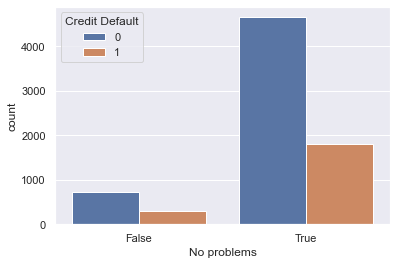

In [153]:
sns.countplot(x="No problems", hue='Credit Default', data=df)
plt.show()

In [154]:
# corr_('No problems', False, True)

In [155]:
# ----------------------
# df['Xrien'] = df['Annual Income'].isnull() & df['Credit Score'].isnull()
# df_test['Xrien'] = df_test['Annual Income'].isnull() & df_test['Credit Score'].isnull()
# ----------------------
# df['Big monthly Debt'] = df['Monthly Debt'] >= (df['Annual Income']/12)*0.2
# df_test['Big monthly Debt'] = df_test['Monthly Debt'] >= (df_test['Annual Income']/12)*0.2

## Обзор целевой переменной. Credit Default <a name=17_cd>

[к оглавлению](#index)

In [156]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

## Смотрим, что получилось <a name=look>

[к оглавлению](#index)

In [157]:
# смотрим train

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Home Ownership                     7500 non-null   object 
 1   Annual Income                      7500 non-null   float64
 2   Years in current job               7500 non-null   float64
 3   Tax Liens                          7500 non-null   float64
 4   Number of Open Accounts            7500 non-null   float64
 5   Years of Credit History            7500 non-null   float64
 6   Maximum Open Credit                7500 non-null   float64
 7   Number of Credit Problems          7500 non-null   float64
 8   Months since last delinquent       7500 non-null   float64
 9   Bankruptcies                       7500 non-null   float64
 10  Purpose                            7500 non-null   float64
 11  Term                               7500 non-null   float

In [158]:
# переделываем Purpose во FLOAT, потому-что некоторые алгоритмы отказываются работать с object

# df['Home Ownership'] = df['Home Ownership'].astype(float)
# df_test['Home Ownership'] = df_test['Home Ownership'].astype(float)

df['Purpose'] = df['Purpose'].astype(float)
df_test['Purpose'] = df_test['Purpose'].astype(float)


In [159]:
# выбираем рабочие столбцы

COL_SELECTED = [
    'Months since last delinquent NULL',
    'Current Loan Amount BIG',
    'Credit Score NULL',
    'No problems',
    
#         'Home Ownership',
        'Annual Income',
        'Years in current job',
#         'Tax Liens',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
#         'Number of Credit Problems',
        'Months since last delinquent',
#         'Bankruptcies',
        'Purpose',
        'Term',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
    
        'Home Ownership_Have Mortgage',
        'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home',
        'Home Ownership_Rent',
    
#         'Purpose_business loan',
#         'Purpose_buy a car',
#         'Purpose_buy house',
#         'Purpose_debt consolidation',
#         'Purpose_educational expenses',
#         'Purpose_home improvements',
#         'Purpose_major purchase',
#         'Purpose_medical bills',
#         'Purpose_moving',
#         'Purpose_other',
# #         'Purpose_renewable energy',
#         'Purpose_small business',
#         'Purpose_take a trip',
#         'Purpose_vacation',
#         'Purpose_wedding'
                         ]

In [160]:
# выбираем числовые столбцы (понадобятся, чтобы статистику строить)

COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
                         ]

Annual Income
MannwhitneyuResult(statistic=9368050.0, pvalue=0.4778190577773966)


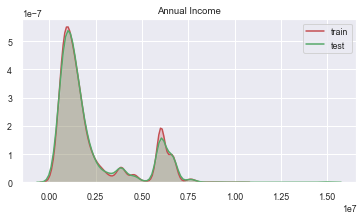

Years in current job
MannwhitneyuResult(statistic=9325493.5, pvalue=0.3434769891811027)


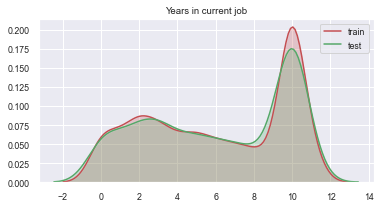

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


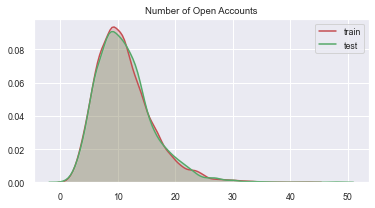

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


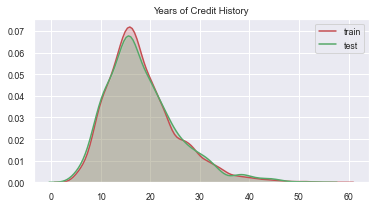

Maximum Open Credit
MannwhitneyuResult(statistic=9316408.5, pvalue=0.3196357886760006)


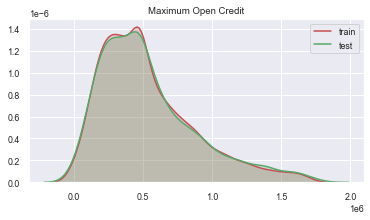

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


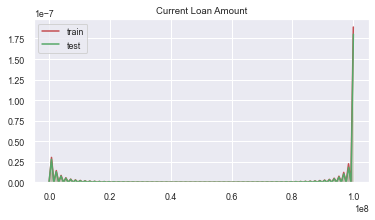

Current Credit Balance
MannwhitneyuResult(statistic=9337526.0, pvalue=0.3821751106458156)


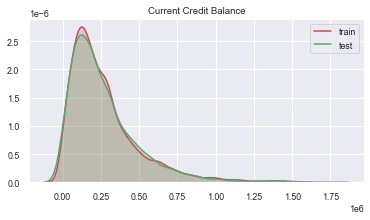

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.2369733356229915)


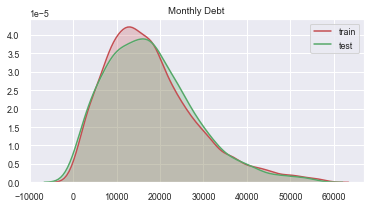

Credit Score
MannwhitneyuResult(statistic=9371108.5, pvalue=0.48705928090901335)


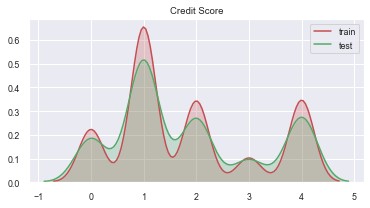

In [161]:
# смотрим похоже-ли распределение непрерывных показателей на train и test

from scipy.stats import mannwhitneyu

# p > 5% - распределения похожи
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

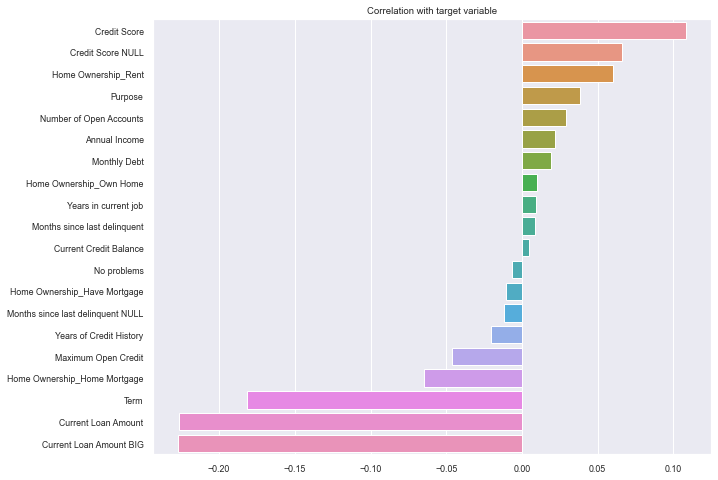

In [162]:
# смотрим влияния столбцов на целевой признак

corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

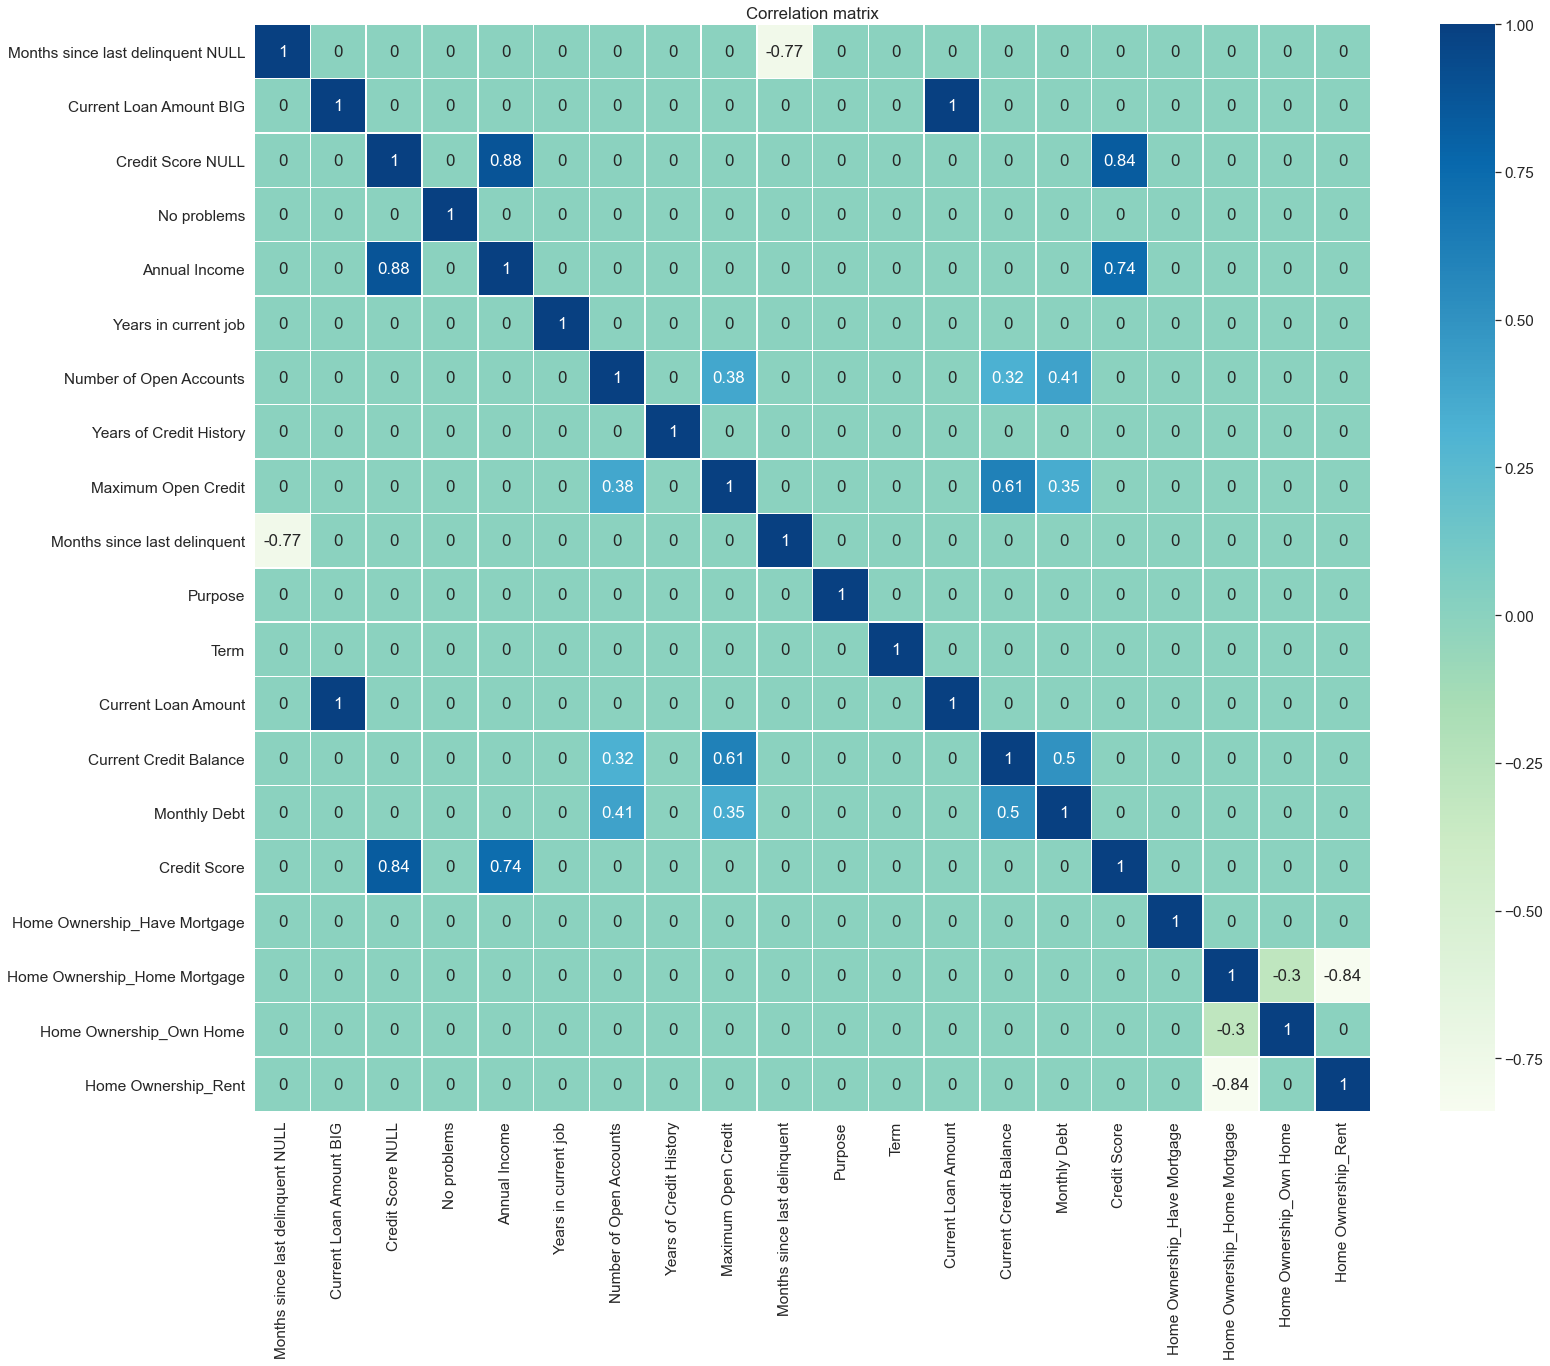

In [163]:
# матрица корреляции

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[COL_SELECTED].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Нормализация данных <a name=norm>
    
[к оглавлению](#index)

In [164]:
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[COL_SELECTED_NUM] = scaler.fit_transform(df_norm[COL_SELECTED_NUM])

# df = df_norm.copy()

In [165]:
# df.head()

In [166]:
# df['Years in current job'] = df['Years in current job'].astype(str)
# df['Purpose'] = df['Purpose'].astype(str)
# df['Term'] = df['Term'].astype(str)
# df['Credit Score'] = df['Credit Score'].astype(str)


# CAT_FEATURE_NAMES = [    
#     'Years in current job', 
#     'Purpose', 
#     'Term', 
#     'Credit Score',    
# ]

In [167]:
# # балансеровка целевой переменной
# def balance_df_by_target(df, target_name):

#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

#     for i in range(disbalance_coeff):
#         sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
#         df = df.append(sample, ignore_index=True)

#     return df.sample(frac=1) 

# балансеровка целевой переменной УЛУЧШЕННАЯ
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

## Обучение на моделях <a name=20_learn>
    
[к оглавлению](#index)

In [168]:
X = df[COL_SELECTED]
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
#                                                     stratify=y,
                                                    test_size=0.30, 
                                                    random_state=21)

In [169]:
# Балансировка целевой переменной

# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
    
# df_balanced['Credit Default'].value_counts()

In [170]:
# X_train = df_balanced.drop(columns='Credit Default')
# y_train = df_balanced['Credit Default']

In [171]:
# смотрим как сбалансирована целевая переменная

disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [175]:
# pip install imblearn

In [176]:
# решаем дисбалланс с использованием алгоритма SMOTE из библиотеки imblearn

# from imblearn.over_sampling import SMOTE

In [178]:
# sm = SMOTE(random_state=42)
# X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
# print(len(X_SMOTE), len(y_SMOTE))
# print(y_SMOTE.sum())

In [179]:
# X_train

In [180]:
# X_SMOTE

In [183]:
def pred_model(model):
    model.fit(X_train, y_train)

#     y_train_pred = model.predict(X_train)
#     y_train_pred = model.predict(X_SMOTE)
    
    y_test_pred = model.predict(X_test)
    

#     print('*'*15)
#     print(model)
    print(model, '  --  ', f1_score(y_test, y_test_pred))
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    

## Список моделей с начальными гиперпараметрами <a name=21_learn1>
    
[к оглавлению](#index)

In [184]:
for model in [
#             Логистическая регрессия
            LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50), 

            xgb.XGBClassifier(eval_metric="logloss", random_state=21),
            KNeighborsClassifier(), # К-ближайших соседей
            BaggingClassifier(), # Беггинг
            RandomForestClassifier(), # Случайный лес
    
#             Дерево решений
            DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:3.1},
                                    max_depth=4
                                    ),
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.1}, random_state=21),
            catb.CatBoostClassifier(class_weights=[1, 3.1], 
                                    iterations=300,
                                    max_depth=6,
                                    l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
                                    early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
                                    random_state=21),
            AdaBoostClassifier(),    
            SVC(), # Метод опорных векторов
            GaussianNB(),
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
            Perceptron(class_weight='balanced')    
]:
        pred_model(model)

LogisticRegression(C=5, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear')   --   0.498216409036861
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)   --   0.42843040473840077
KNeighborsClassifier()   --   0.26877470355731226
BaggingClassifier()   --   0.4201853759011328
RandomForestClassifier()   --   0.43535911602209953
DecisionTreeClassifier(class_weight={0: 1, 1: 3.1}, max_depth=4,


In [185]:
# # отдельно модель CatBoost

# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.1], 
#                                     iterations=300,
#                                     max_depth=6,
# #                                     cat_features=CAT_FEATURE_NAMES,
#                                     silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
# #                                     use_best_model=True,
#                                     random_state=21)

# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# print(model_catb, '  --  ', f1_score(y_test, y_test_pred))

In [186]:
# ансамбль на лучших моделях

model_vote = VotingClassifier(
    estimators=[
#         ('Logistic Regression', 
#                  LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50)),
#         ('XGBoost', xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=21)),
#         ('K-Neighbours', KNeighborsClassifier()),
#         ('DecisionTree', DecisionTreeClassifier(random_state=21,
#                                     class_weight={0:1, 1:3.6},
#                                     max_depth=4
#                                     )),
        ('LightGBM', lgbm.LGBMClassifier(class_weight={0:1, 1:3.1}, random_state=21)),
        ('CatBooster', 
                            catb.CatBoostClassifier(class_weights=[1, 3.1], 
                                    iterations=400,
                                    depth=3,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
                                    l2_leaf_reg=300,
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
                                    random_state=21)),
#         ('Ada Boost', AdaBoostClassifier()),
#         ('SVM', SVC()),
#         ('Naive Bayes', GaussianNB()),
        ('Extra Tree', 
                ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced')),
#         ('Gradient Boosting', GradientBoostingClassifier(learning_rate=7, random_state=42)),
#         ('Perceptron', Perceptron(class_weight='balanced'))
    ],
    voting='hard',
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

print(f1_score(y_test, y_test_pred))

0.5380875202593193


### Выбор гиерпараметров CatBoost

In [187]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.1], silent=True, random_state=21)

In [188]:
# params = {'n_estimators':[50, 100, 200, 300, 400, 500],
#           'max_depth':[3, 4, 5, 6, 7]}

In [189]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [192]:
# %%time

# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X, y)

In [193]:
# rs.best_params_

In [194]:
# rs.best_score_

In [196]:
# rs

In [197]:
# params_model = {
#     'eval_metric': 'F1',
# #     'auto_class_weights': 'Balanced',
#     'silent': True,
#     'one_hot_max_size': 20,
#     'early_stopping_rounds': 50,
#     'boosting_type': 'Ordered',
#     'allow_writing_files': False
# }

final_model = catb.CatBoostClassifier(
#                                     **params_model,
                                    class_weights=[1, 3.1],
                                    depth=3,
#                                     grow_policy = 'Depthwise',
                                    iterations=400,
                                    silent = True,
#                                     learning_rate=0.5,
#                                     l2_leaf_reg=3.5,
#                                     bagging_temperature=1.5
                                )



final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.65      0.76      3771
           1       0.48      0.84      0.61      1479

    accuracy                           0.70      5250
   macro avg       0.70      0.74      0.69      5250
weighted avg       0.79      0.70      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.86      0.59      0.70      1616
           1       0.42      0.76      0.55       634

    accuracy                           0.64      2250
   macro avg       0.64      0.68      0.63      2250
weighted avg       0.74      0.64      0.66      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               961  655
1               150  484


In [198]:
# def init_models():
#     model_lr = LogisticRegression(random_state=21)
#     model_knn = KNeighborsClassifier()
#     model_tree = DecisionTreeClassifier(random_state=21)
#     model_xgb = xgb.XGBClassifier(random_state=21)
#     model_lgbm = lgbm.LGBMClassifier(random_state=21)
#     model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

#     models = {
#         'lr': model_lr,
#         'knn': model_knn,
#         'tree': model_tree,
#         'xgb': model_xgb,
#         'lgbm': model_lgbm,
#         'cat': model_catb
#     }
#     return models

In [199]:
# def get_metrics(report):
#     f1_macro = report['macro avg']['f1-score']
#     f1_0 = report['0']['f1-score']
#     f1_1 = report['1']['f1-score']
#     return f1_macro, f1_0, f1_1

In [200]:
# def run_experiment(X_train, X_test, y_train, y_test, method='not'):
#     assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
#     models = init_models()
    
#     stata = pd.DataFrame()
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         pred_train = model.predict(X_train)
#         pred_test = model.predict(X_test)

#         report_train = classification_report(y_train, pred_train, output_dict=True)
#         report_test = classification_report(y_test, pred_test, output_dict=True)
#         f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
#         f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

#         stata = stata.append({
#             'model_name': name,
#             f'f1_macro_train_{method}': f1_macro_train,
#             f'f1_macro_test_{method}': f1_macro_test,
#             f'f1_0_train_{method}': f1_0_train,
#             f'f1_0_test_{method}': f1_0_test,
#             f'f1_1_train_{method}': f1_1_train,
#             f'f1_1_test_{method}': f1_1_test
#         }, ignore_index=True)
#     return stata, models

In [201]:
# %%time
# stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
# stata_not_balanced

In [203]:
# # сохраняем результат

# df_test["Credit Default"] = model_vote.predict(df_test[COL_SELECTED])
df_test["Credit Default"] = final_model.predict(df_test[COL_SELECTED])
# df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])


df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID'] + 7500
df_test1 = df_test[['Credit Default', 'ID']]
df_test1.to_csv(r'_lesson__24cat__.csv', index=False)

**Урок 3. Теория**

1. Для чего и в каких случаях полезны различные варианты усреднения для метрик качества классификации: micro, macro, weighted?

micro - это по-сути **accuracy**

macro - простое среднее (не уитывает дисбаланс классов)

weighted - рассчитывает среднее **с учетом дисбалланса классов**

2. В чём разница между моделями xgboost, lightgbm и catboost или какие их основные особенности?

Основные отличия в том, как строятся деревья, как объединяются фичи и в скорости работы (lightgbm - самая быстрая, catboost - самая медленная)

**Урок 2. Теория**

1. В чём различие между зависимыми и независимыми выборками?

В зависимых выборках изменения в одной выборке как-то влияют на изменения в другой выборке.<br>
В независимых выборках изменения в одной выборке вообще никак не влияет на другую выборку.

2. Когда применяются параметрические статистические критерии, а когда — их непараметрические аналоги?

Параметрические критерии: нормальное распределение, достаточный объем выборки, количественная информация (числа)
Непараметрические критерии: распределение отличное от нормального, малый объем выборки, может быть неколичественная информация

**Домашка 1. Теоретический вопросы.**

1. Приведите по 2 примера, когда лучше максимизировать Precision, а когда Recall.

Precision (точность): используется, когда важно не ошибиться при обнаружении искомых объектов. Примеры: `1- обнаружение магазинных воришек` (важно не только найти воришек, но и не обвинить невиновных) или `2- диагностика тяжелых, но трудно диагностируемых заболеваний`.
Т.е. мы должны быть уверенны, когда относим что-то к искомому классу.

Recall (полнота): использутеся, когда нам важно найти максимальное количество объектов искомого класса. Примеры: `1- обнаружение нарушителей на КПП важного объекта` или `2- обнаружение террористов`. 
Т.е. можно позволить себе ошибаться, главное - не пропустить виновных.

2. Почему мы используем F-меру, почему, например, нельзя просто взять среднее от Precision и Recall?

`F-мера это гармоническое среднее. Т.е. по сути это тоже среднее, но с возможностью регулировать величину значения вкладв в этот показатель Точности и Посноты при такой необходимости. `